In [ ]:
# Installing the dataset - Need kaggle.json file
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download chrisfilo/fruit-recognition
! unzip fruit-recognition.zip -d archive -p
! mkdir archive
! unzip fruit-recognition.zip -d archive

In [ ]:
# Required libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import cv2
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle

import keras
from keras import Sequential, layers, regularizers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Fixing seed
np.random.seed(1) # Add random seed of training for reproducibility

# Read images from folder
def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [ ]:
# Get images from every folder
images = []
dirp = "/content/archive/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
df = pd.DataFrame(images, columns = ["fruit", "path"])

# Shuffling the data and their indexes
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Each fruit type gets a unique number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

df

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


,fruit,path,label
0,Orange,/content/archive/Orange/Orange001077.png,6
1,Mango,/content/archive/Mango/Mango001722.png,5
2,Guava,/content/archive/Guava/Guava total/1GuavaуАВ25...,3
3,Peach,/content/archive/Peach/Peach001522.png,7
4,Guava,/content/archive/Guava/Guava total/GuavaуАВ167...,3
...,...,...,...
70544,Kiwi,/content/archive/Kiwi/kiwi A/Kiwi A00507.png,4
70545,Guava,/content/archive/Guava/Guava total/GuavaуАВ218...,3
70546,Guava,/content/archive/Guava/Guava total/GuavaуАВ327...,3
70547,Guava,/content/archive/Guava/Guava total/GuavaуАВ184...,3


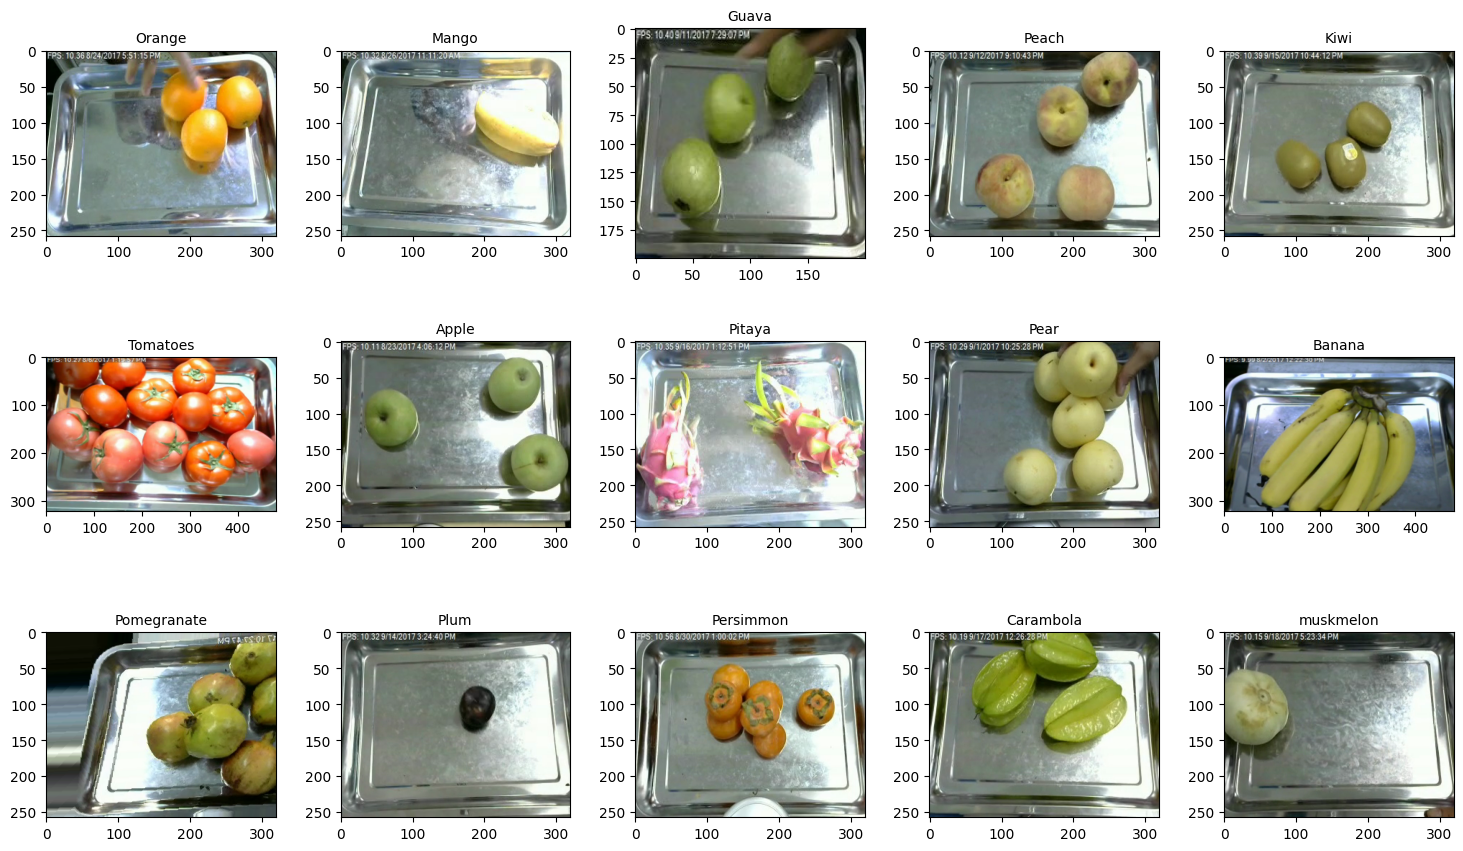

In [ ]:
# Print each image in 50x50 pixel
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
uniq  = set()
for i, ax in enumerate(axes.flat):
    if(df.fruit[i] in uniq):
      a = i
      for x in range(250):
        if(df.fruit[a] not in uniq):
          i = a
        a = a + 1

    if(df.fruit[i] not in uniq):

      uniq.add(df.fruit[i])
      ax.imshow(plt.imread(df.path[i]))
      ax.set_title(df.fruit[i], fontsize = 10)
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
# To train and test 
def image_load(df):

    path = df["path"].values
    path_label = df["label"].values

    X = list()
    y = list()
    
    for i,path in enumerate(path):
        img = cv2.resize(plt.imread(path), (50,50))
        label = path_label[i]
        X.append(img)
        y.append(label)

    return np.array(X),np.array(y)

In [ ]:
# CNN Model
model = Sequential()

#Feature Extraction Part
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(50,50,3), activation='relu', padding = 'same',kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(50,50,3), activation='relu', padding = 'same',kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(50,50,3), activation='relu', padding = 'same',kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(50,50,3), activation='relu', padding = 'same',kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected 
#Classification Part
model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(15))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Train + validation dataset
X, y = image_load(df.iloc[0:14109])

In [ ]:
from sklearn.model_selection import train_test_split
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1)

In [ ]:
y_train

array([ 9,  5,  2, ...,  3, 12,  1])

In [ ]:
#Converts a class vector (integers) to binary class matrix.
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# If there is no improvement then it will stop to prevent overfitting
# Also, It takes the best one.
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# Record the history of the model
hists = list()
# Fitting the model - Different batch sizes tested (8,16,32,64,128,256) --> Best result = 64
model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=callbacks,validation_data=(X_val, y_val), verbose = 1)
hists.append(model.history.history)

Epoch 1/50
177/177 [==============================] - 49s 269ms/step - loss: 3.3498 - accuracy: 0.2997 - val_loss: 2.8911 - val_accuracy: 0.3338
Epoch 2/50
177/177 [==============================] - 45s 257ms/step - loss: 2.4230 - accuracy: 0.3803 - val_loss: 2.1690 - val_accuracy: 0.3912
Epoch 3/50
177/177 [==============================] - 43s 242ms/step - loss: 1.9097 - accuracy: 0.4910 - val_loss: 1.5245 - val_accuracy: 0.5659
Epoch 4/50
177/177 [==============================] - 43s 243ms/step - loss: 1.4532 - accuracy: 0.6282 - val_loss: 1.8027 - val_accuracy: 0.5223
Epoch 5/50
177/177 [==============================] - 45s 255ms/step - loss: 1.2778 - accuracy: 0.6549 - val_loss: 1.2382 - val_accuracy: 0.6510
Epoch 6/50
177/177 [==============================] - 42s 239ms/step - loss: 1.0236 - accuracy: 0.7320 - val_loss: 0.8760 - val_accuracy: 0.7654
Epoch 7/50
177/177 [==============================] - 44s 249ms/step - loss: 1.0315 - accuracy: 0.7381 - val_loss: 0.9306 - val_ac

In [ ]:
# Get the best model
model.load_weights("best_model.h5")

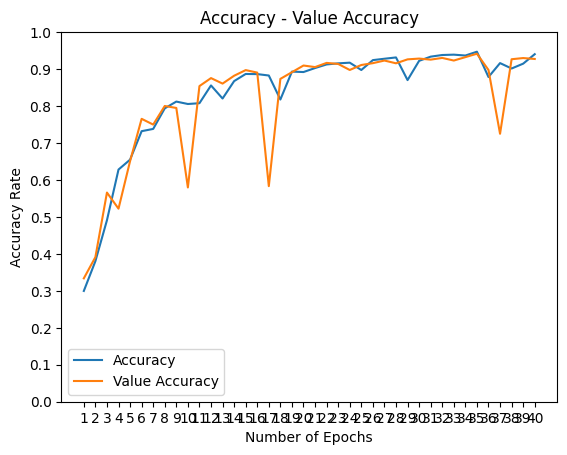

In [ ]:
# Plotting Accuracy - Value Accuracy / Epoch graphs
epochs = [e for e in range(1,len(hists[0]["accuracy"])+1)]

plt.plot(epochs, hists[0]["accuracy"], label = "Accuracy") 
plt.plot(epochs, hists[0]["val_accuracy"], label = "Value Accuracy")
  
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy - Value Accuracy')

plt.ylim(0,1)
plt.xticks(epochs)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.legend()
  
plt.show()

In [ ]:
# Test split and predictions
X_test, y_test = image_load(df.iloc[67013:70540])
pred = np.argmax(model.predict(X_test), axis=1)

111/111 [==============================] - 3s 30ms/step


In [ ]:
# Performance metrics of the CNN
print("Performance Metrics:\n")
print(classification_report(y_test, pred, target_names=fruit_names))

Performance Metrics:

              precision    recall  f1-score   support

       Apple       0.91      0.92      0.92       576
      Banana       0.79      0.83      0.81       151
   Carambola       0.99      0.95      0.97       104
       Guava       0.99      0.99      0.99       938
        Kiwi       0.98      0.99      0.99       472
       Mango       0.90      0.93      0.92       213
      Orange       0.96      0.98      0.97       160
       Peach       0.94      0.93      0.94       134
        Pear       0.86      0.96      0.91       154
   Persimmon       0.97      0.93      0.95       111
      Pitaya       0.96      0.92      0.94       107
        Plum       0.99      0.97      0.98       110
 Pomegranate       0.99      0.77      0.87       102
    Tomatoes       0.93      0.96      0.94       117
   muskmelon       0.84      0.74      0.79        78

    accuracy                           0.94      3527
   macro avg       0.93      0.92      0.92      3527
weig

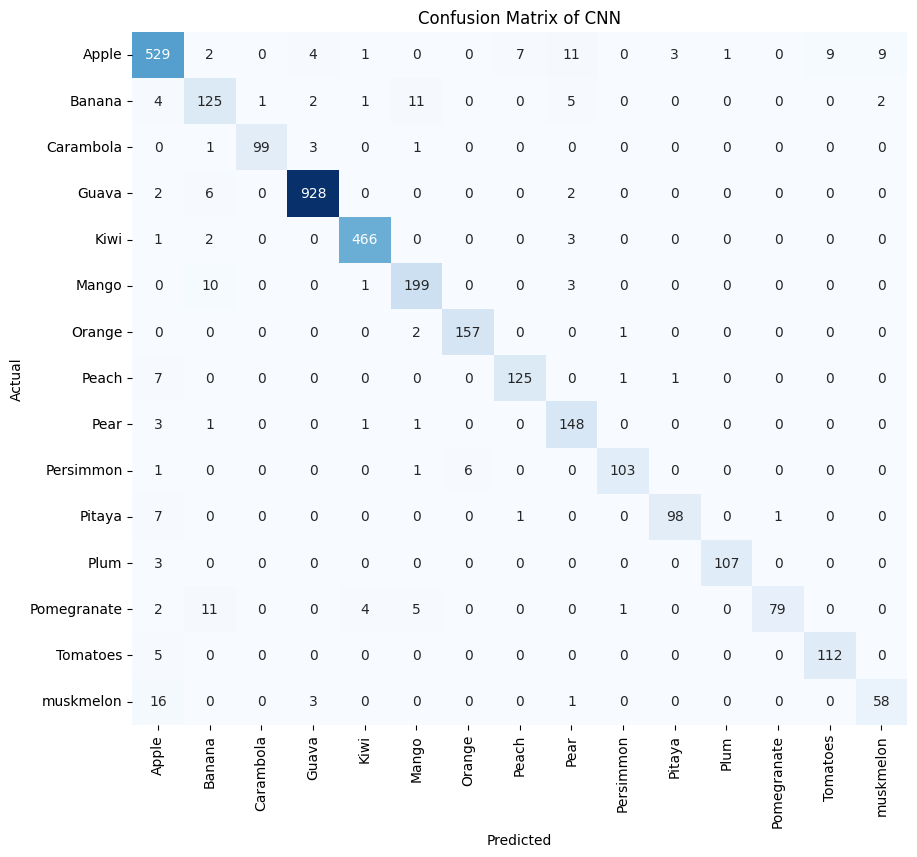

In [ ]:
# Confusion matrix of the CNN
confusionMatrix = pd.DataFrame(confusion_matrix(y_test, pred), columns=fruit_names, index = fruit_names)
confusionMatrix.index.name = 'Actual'
confusionMatrix.columns.name = 'Predicted'


plt.subplots(figsize=(10, 9))

sns.heatmap(confusionMatrix, cbar=False, annot=True, cmap="Blues", fmt='.0f')
plt.title('Confusion Matrix of CNN')
plt.show()

In [ ]:
# Accuracy score of our model in the test dataset
accuracy_score(y_test, pred)

0.9449957470938475

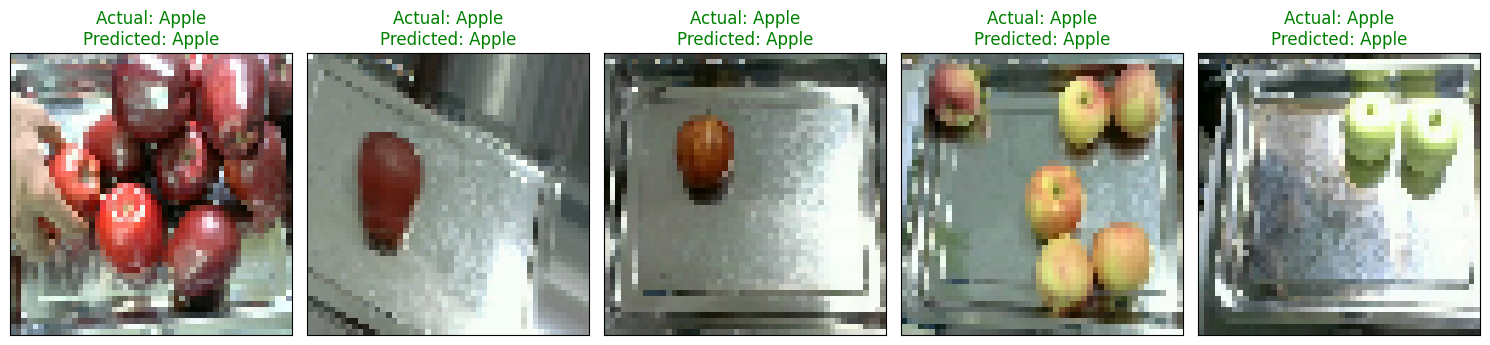

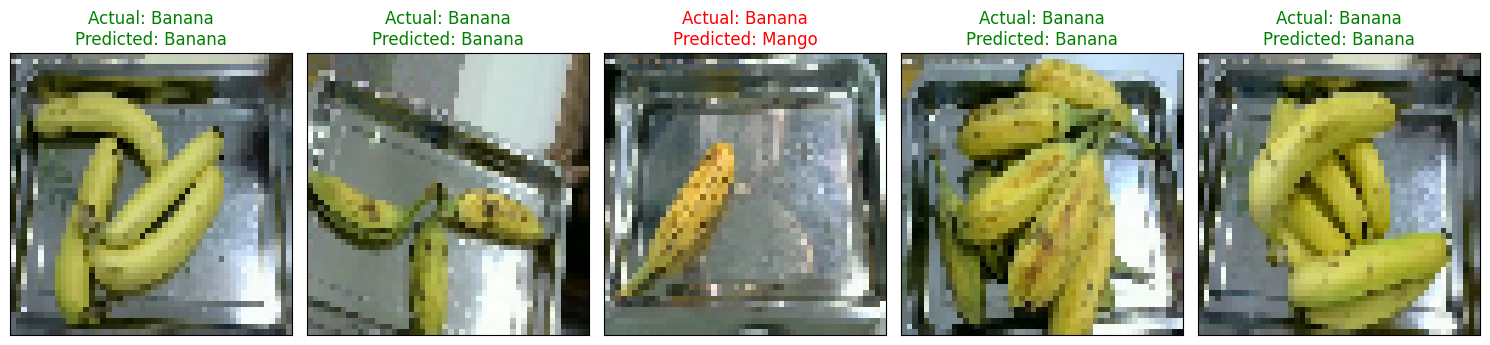

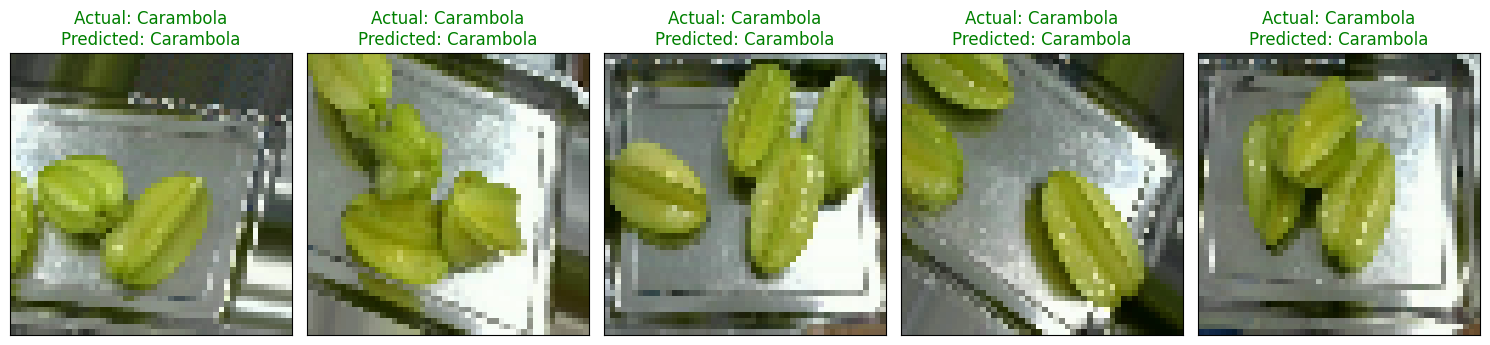

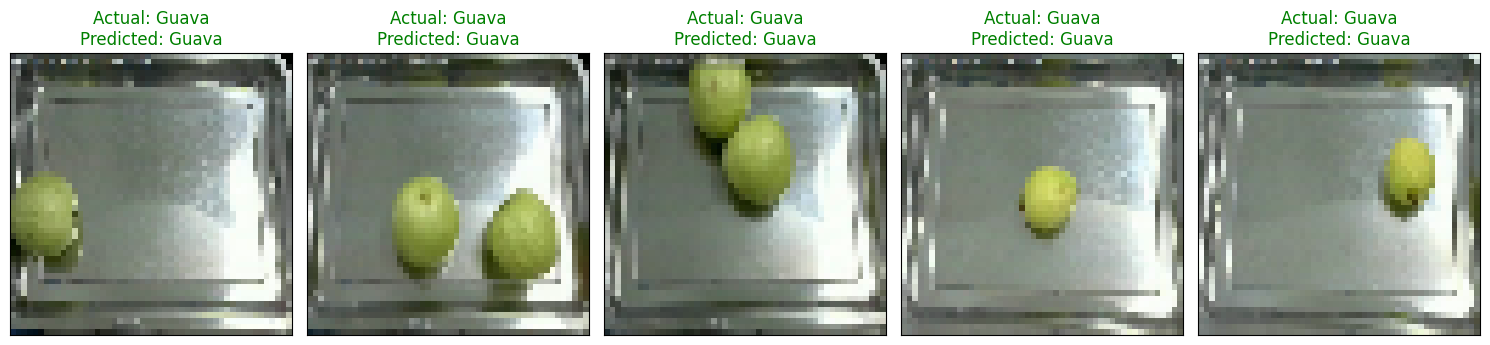

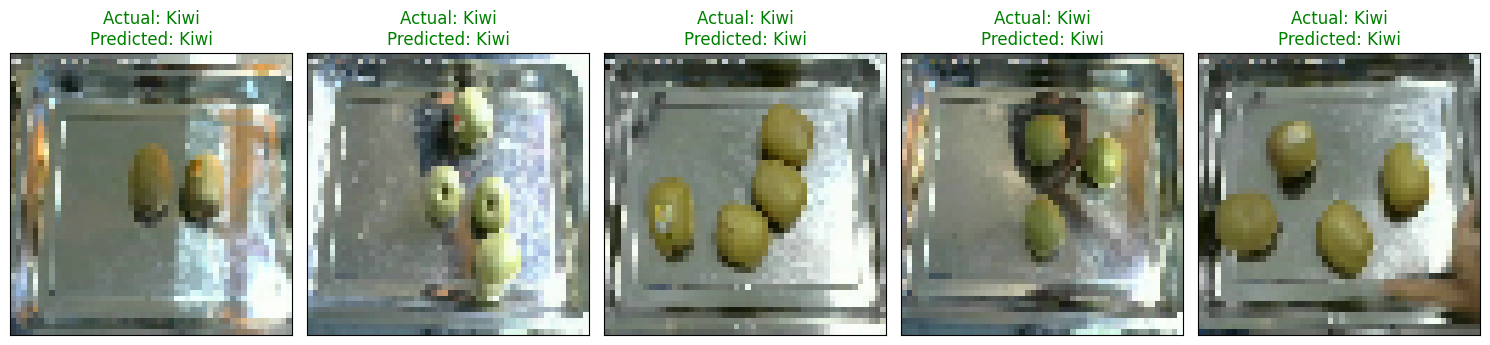

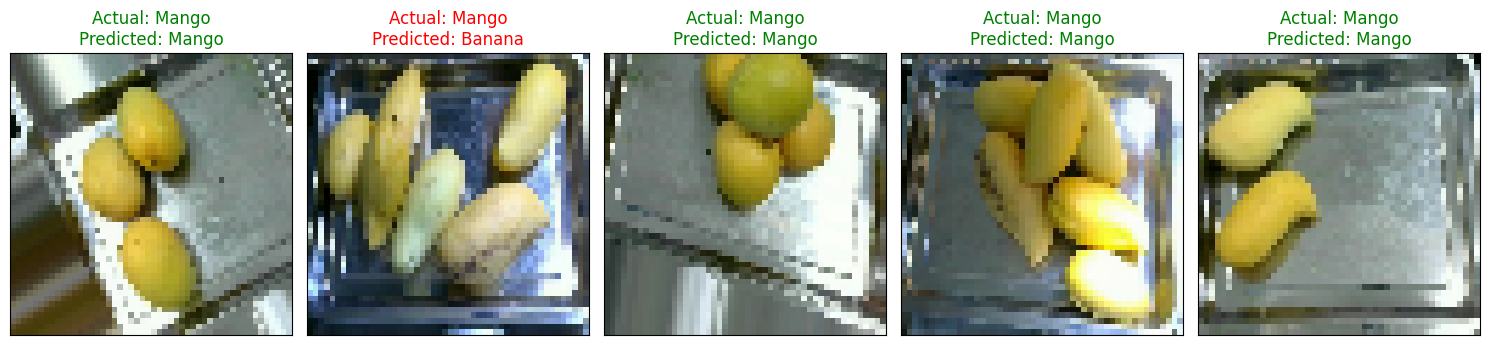

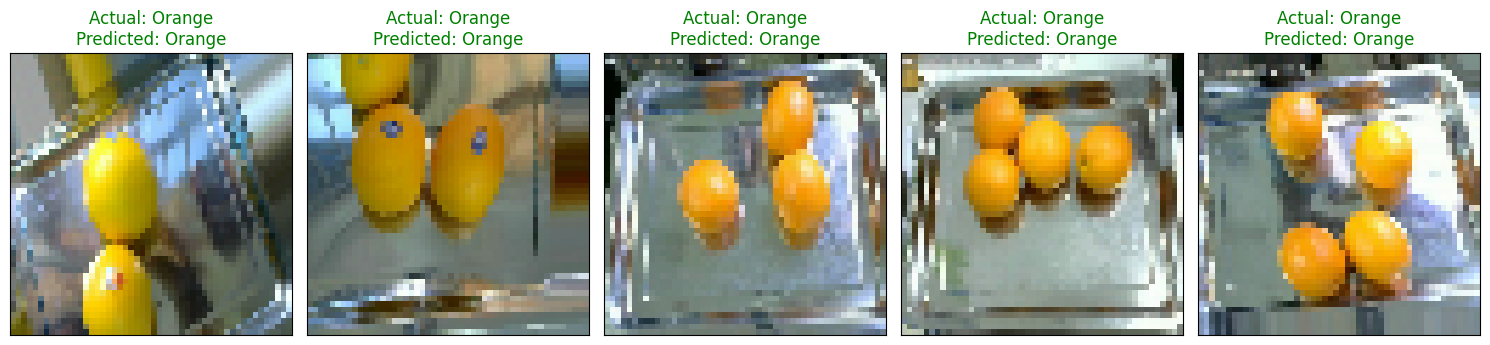

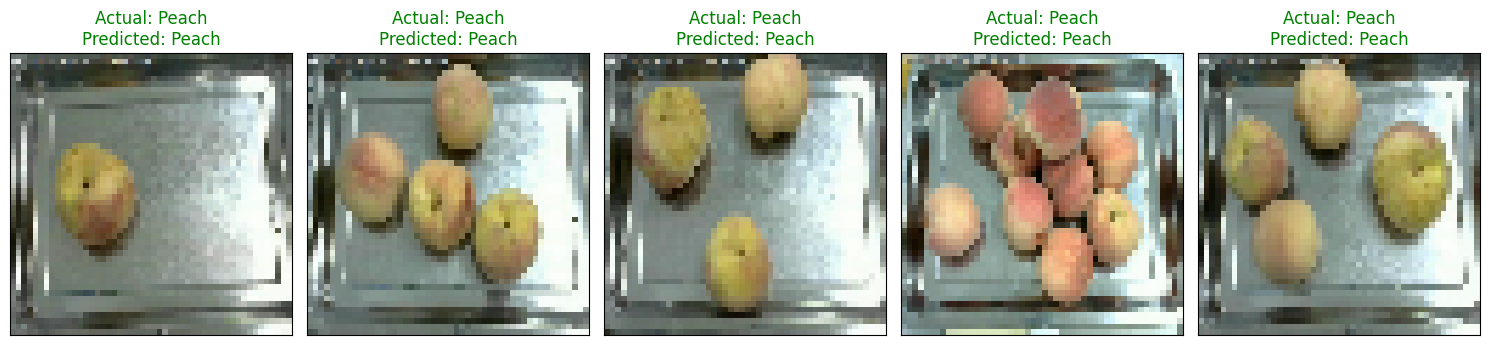

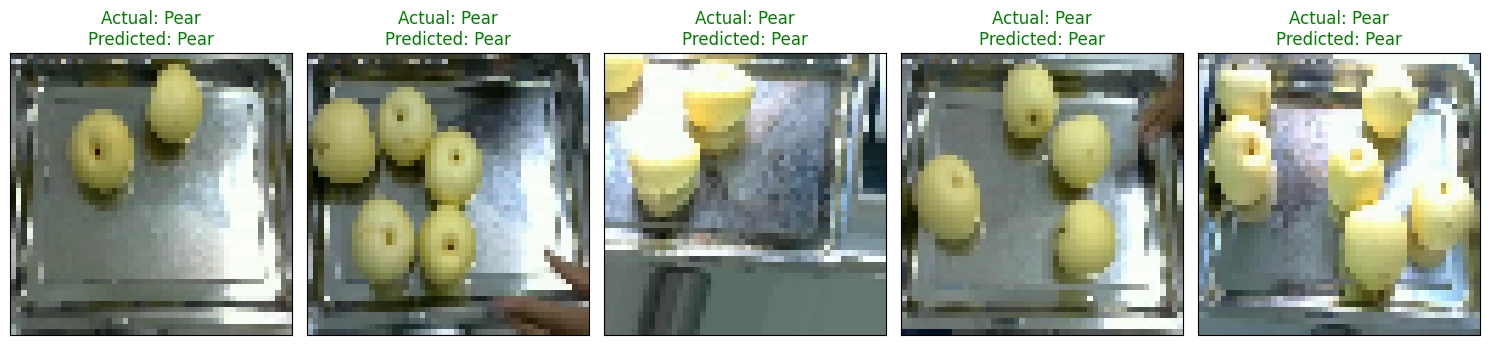

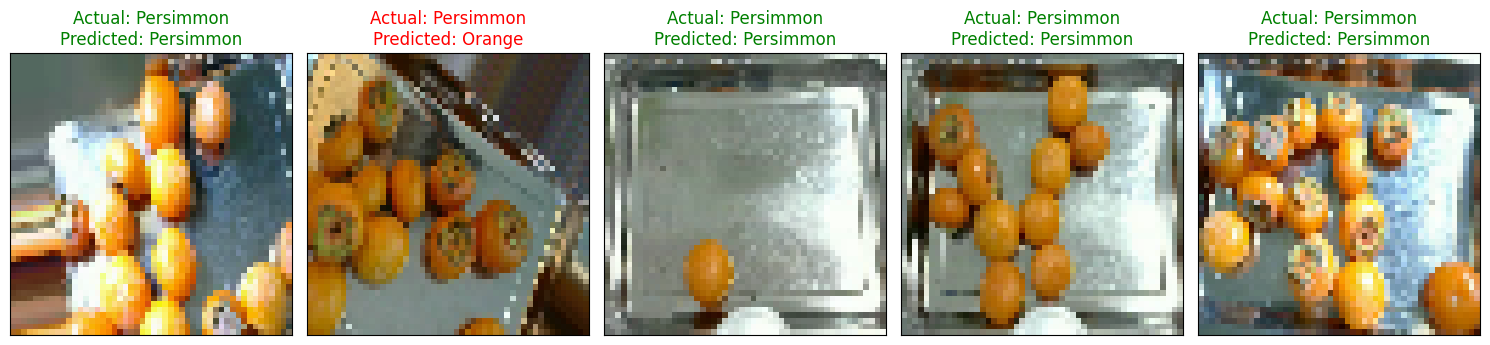

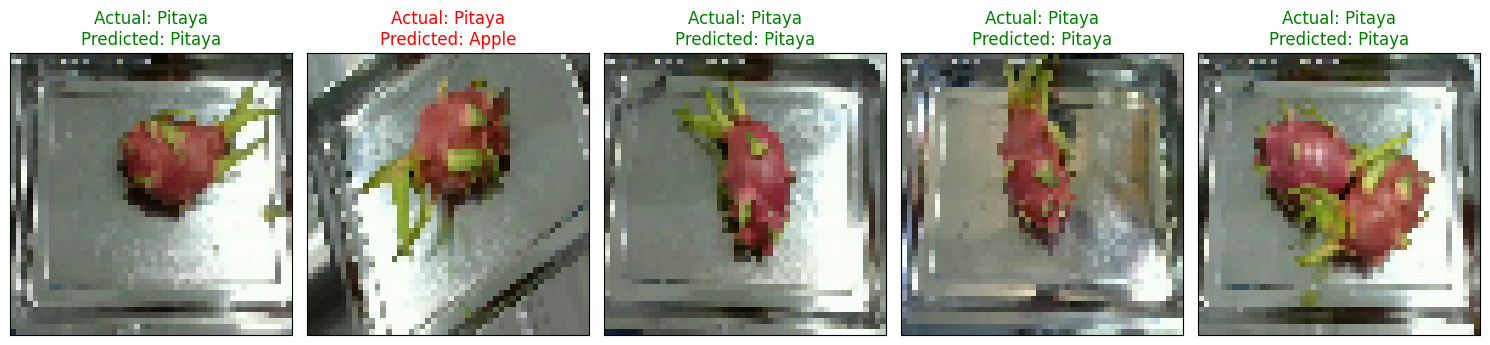

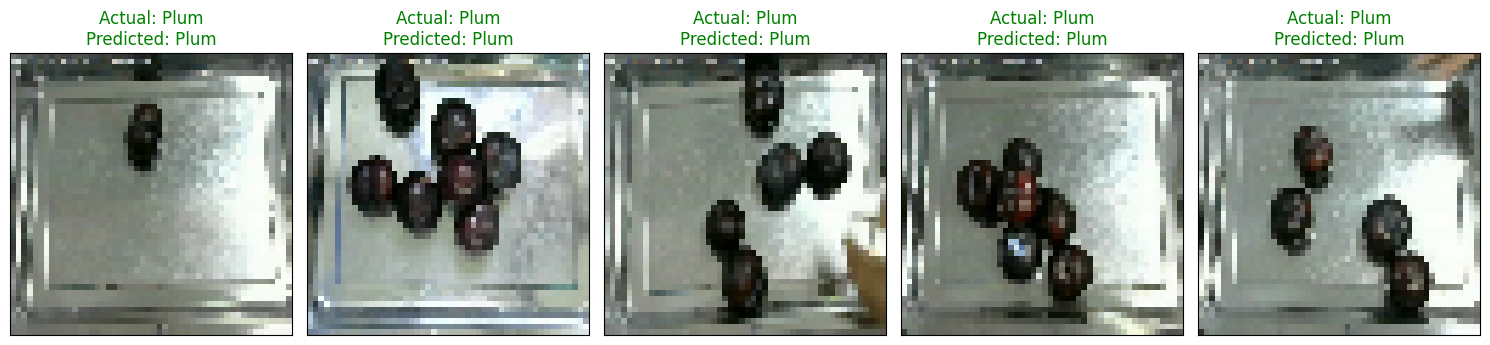

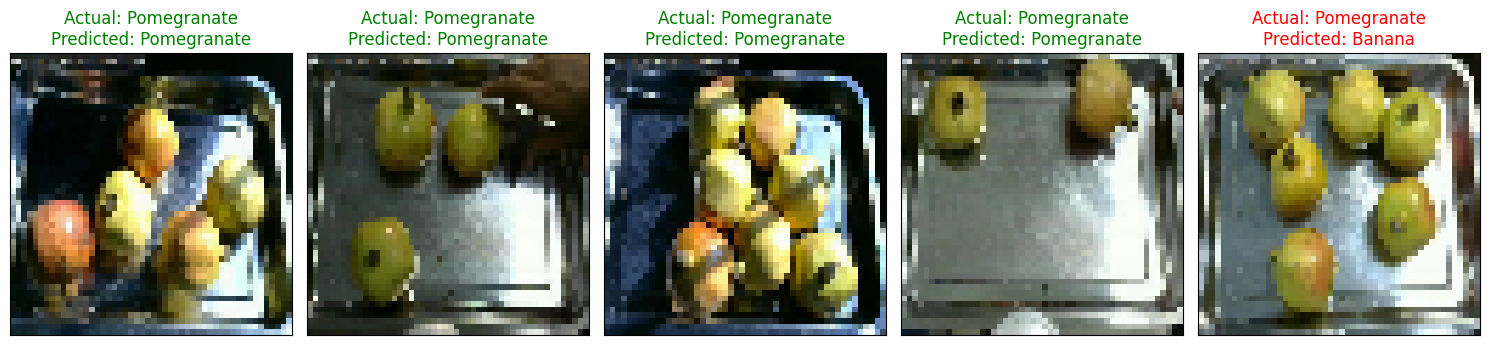

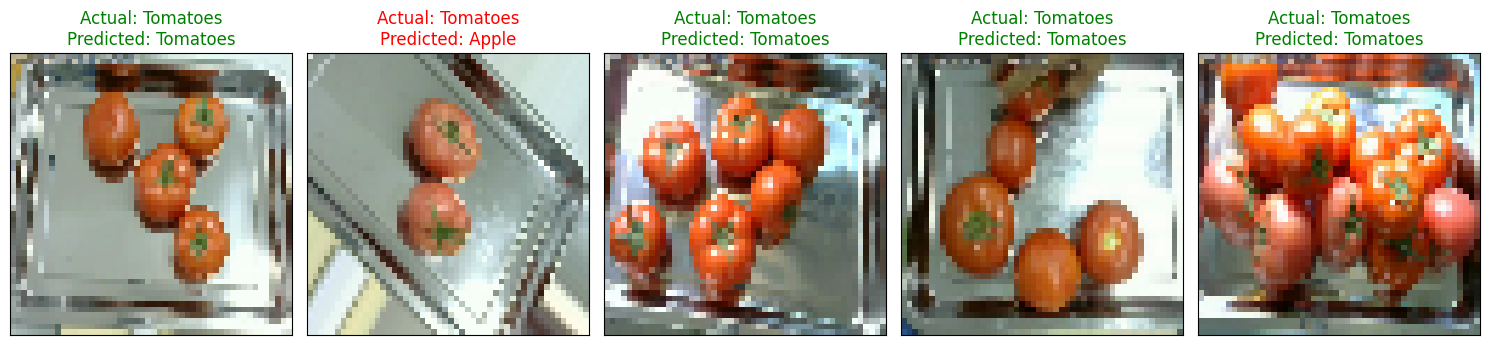

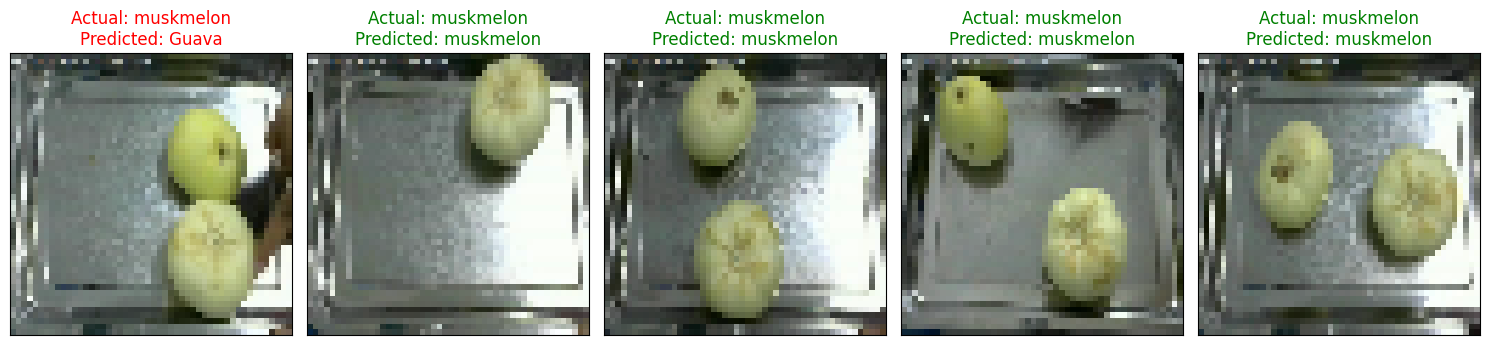

In [ ]:
# Sample Predictions
x = 0
currFruit = fruit_names[x]
fruit = set()

for visitFruit in fruit_names:
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
  for i, ax in enumerate(axes.flat):
      for n in range(y_test.size):
        if fruit_names[y_test[-n]] is visitFruit and n not in fruit:
          fruit.add(n)
          ax.imshow(X_test[-n])
          ax.set_title(f"Actual: {fruit_names[y_test[-n]]}\nPredicted: {fruit_names[pred[-n]]}", color= "green" if fruit_names[y_test[-n]] == fruit_names[pred[-n]] else "red" )
          break

  plt.tight_layout()
  plt.show()